# **Data Pre-Processing**

In [2]:
import pandas as pd
# retail = "Online Retail.xlsx"
retail = "../data/Online Retail.xlsx" # use this for using local data within the repo.
df = pd.read_excel(retail, sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape # Show the dimensiion of dataframe

(541909, 8)

In [4]:
# Find data types of each column
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [5]:
#Check dataframe for missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [6]:
# Calculate the percentage of missing values
null_percentage = df.isnull().sum() / len(df) * 100

# Show missing values percentage
print(null_percentage)


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [7]:
# Drop missing Customer IDs and Description
df.dropna(subset=["CustomerID", "Description"], inplace=True)

In [8]:
# Check the demension of datframe after null removals
df.shape

(406829, 8)

In [9]:
# Convert data types in to the proper types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceNo"] = df["InvoiceNo"].astype(str)

In [10]:
# Remove negative or zero values in Quantity and UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

## **Create RFM Dataframe**


The following block of code calculates three key metrics (Recency, Frequency, and Monetary) for customer segmentation in the Online Retail dataset.

RFM analysis is used to group customers based on their purchase behavior. The three metrics represent:

Recency: How recently a customer made a purchase.

Frequency: How often a customer makes purchases.

Monetary : How much a customer spends.

Recency: Finds the latest purchase date for each customer.Calculates how many days have passed since their last purchase.

Frequency:Counts the number of unique transactions each customer has made.

Monetary: Computes the total spending per customer by multiplying Quantity * UnitPrice and summing the values.


This would help us to identify loyal customers, high spenders, and inactive users.also, it can be used to group customers into categories. We can use the scores to create personalized marketing desicions.

In [11]:
df = df.copy()

# Compute the latest transaction date in the dataset
latest_date = df["InvoiceDate"].max()

# Create "TotalPrice" column manually using .loc to avoid warning
df.loc[:, "TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Compute RFM metrics for each customer
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (latest_date - x.max()).days),  # Days since last purchase
    Frequency=("InvoiceNo", "nunique"),  # Count of unique transactions
    Monetary=("TotalPrice", "sum")  # Total spending amount
).reset_index()  # Reset index

# Display the first five rows
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


**Implementing Initial Cutomer Segmentation Score**

Each metric is scored on a scale, from 1 to 4 using quantiles where lower Recency scores indicate recent engagement, and higher Frequency and Monetary scores reflect loyal and high-spending customers. These individual scores are then combined to create an overall RFM score, which helps categorize customers into meaningful segments

In [12]:
# Create RFM score quartiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # Lower Recency is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # Higher Frequency is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])  # Higher Monetary is better

# Calculate overall RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

# Display the first few rows
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,325,1,77183.60,1,1,4,6
1,12347.0,1,7,4310.00,4,4,4,12
2,12348.0,74,4,1797.24,2,3,4,9
3,12349.0,18,1,1757.55,3,1,4,8
4,12350.0,309,1,334.40,1,1,2,4


In [13]:
# Define customer segments into 3 categories
def segment_customer(score):
    if score >= 8:
        return 'Loyal Customer'            # High RFM Score
    elif score >= 5:
        return 'Potential Loyalist'        # Medium RFM Score
    else:
        return 'At Risk'                   # Low RFM Score

# Apply the function to create 'Segment' column
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Display segment counts
print(rfm['Segment'].value_counts())


Segment
Loyal Customer        2111
Potential Loyalist    1420
At Risk                807
Name: count, dtype: int64


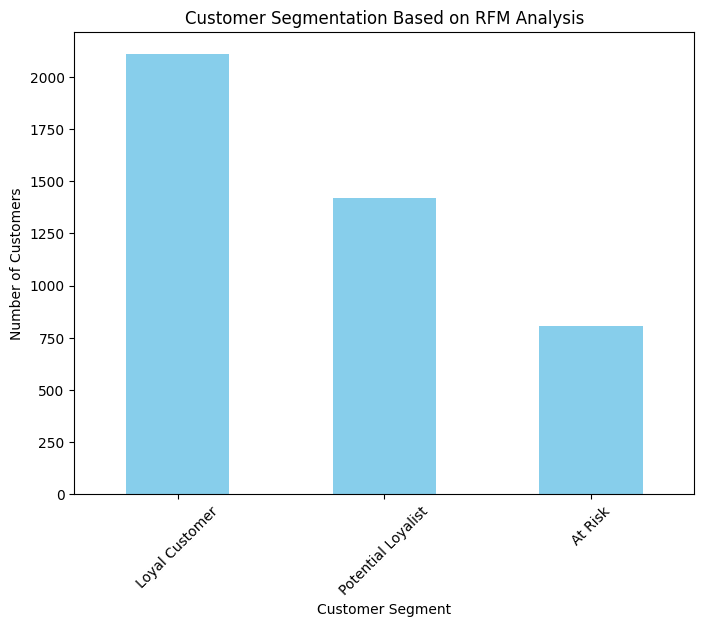

In [14]:
import matplotlib.pyplot as plt

# Plot customer segmentation counts
plt.figure(figsize=(8,6))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Segmentation Based on RFM Analysis')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


**Normalize The Data Using MinMaxScaler**

In [64]:
# Use MinMaxScaler for normalizing the original dataset to be used for algorithms except DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Apply log transformation (adding 1 to avoid log(0) issues)
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to Recency, Frequency, and Monetary
rfm_norm = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

# Convert the result back into a DataFrame
rfm_minmax= pd.DataFrame(rfm_norm, columns=['Recency', 'Frequency', 'Monetary'])


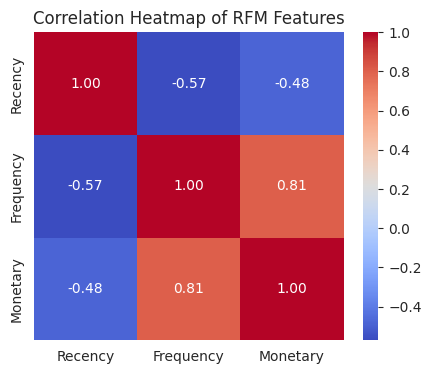

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = rfm_minmax.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of RFM Features")
plt.show()

**Plot To Figure Out The Data Distribution**

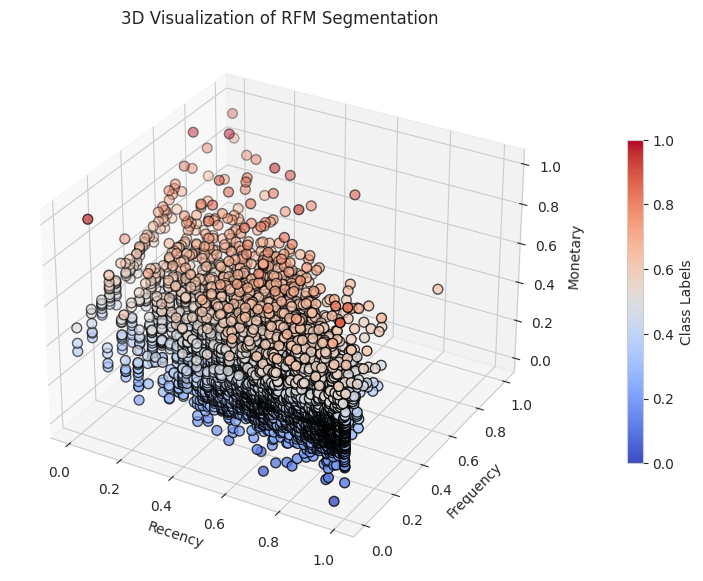

In [66]:
from mpl_toolkits.mplot3d import Axes3D

# Set the style
sns.set_style("whitegrid")

# Create the 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter= ax.scatter(rfm_minmax["Recency"], rfm_minmax["Frequency"], rfm_minmax["Monetary"],
           c=rfm_minmax["Monetary"], cmap="coolwarm", s=50, edgecolor='k')

# Labels and title
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Visualization of RFM Segmentation")

# Add color bar to indicate classes
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Class Labels")

# Show the plot
plt.show()


**Dimension Reduction Usng PCA**

In [67]:
import pandas as pd
from sklearn.decomposition import PCA

# Apply PCA analysis on dataset that normalized using MinMaxscalar
# This would be used for all algorithm except DBSCAN
# Apply pca on datafram using 2 compopnents
pca_minmax = PCA(n_components=2)
rfm_reduced = pca_minmax.fit_transform(rfm_minmax)

# Convert the PCA output to a DataFrame
rfm_df = pd.DataFrame(rfm_reduced, columns=["PCA1", "PCA2"])

In [68]:
from sklearn.preprocessing import StandardScaler

# Apply pca on datafram using 2 compopnents
# This would be used for DBSCAN
scaler = StandardScaler()

# Apply StandardScaler to Recency, Frequency, and Monetary
rfm_standard = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

# Convert the result back into a DataFrame
rfm_scalar= pd.DataFrame(rfm_standard, columns=['Recency', 'Frequency', 'Monetary'])

pca_std = PCA(n_components=2)
rfm_scalar = pca_std.fit_transform(rfm_scalar)

# Convert the PCA output to a DataFrame
rfm_std = pd.DataFrame(rfm_scalar, columns=["PCA1", "PCA2"])


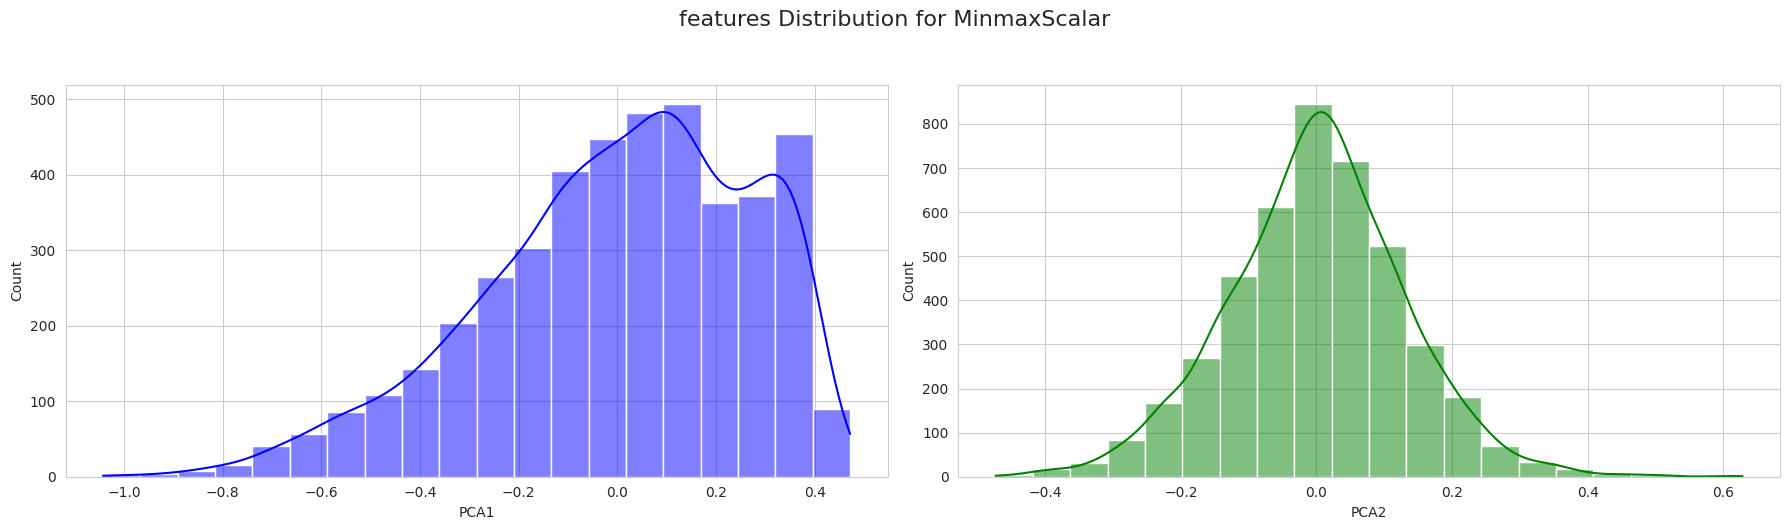

In [69]:
# style of the graph
sns.set_style("whitegrid")

# Subplots for each RFM feature
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot Recency distribution
sns.histplot(rfm_df["PCA1"], bins=20, kde=True, ax=axes[0], color="blue")

# Plot Frequency distribution
sns.histplot(rfm_df["PCA2"], bins=20, kde=True, ax=axes[1], color="green")

# Add main title to the figure
fig.suptitle("features Distribution for MinmaxScalar", fontsize=16, y=1.05)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


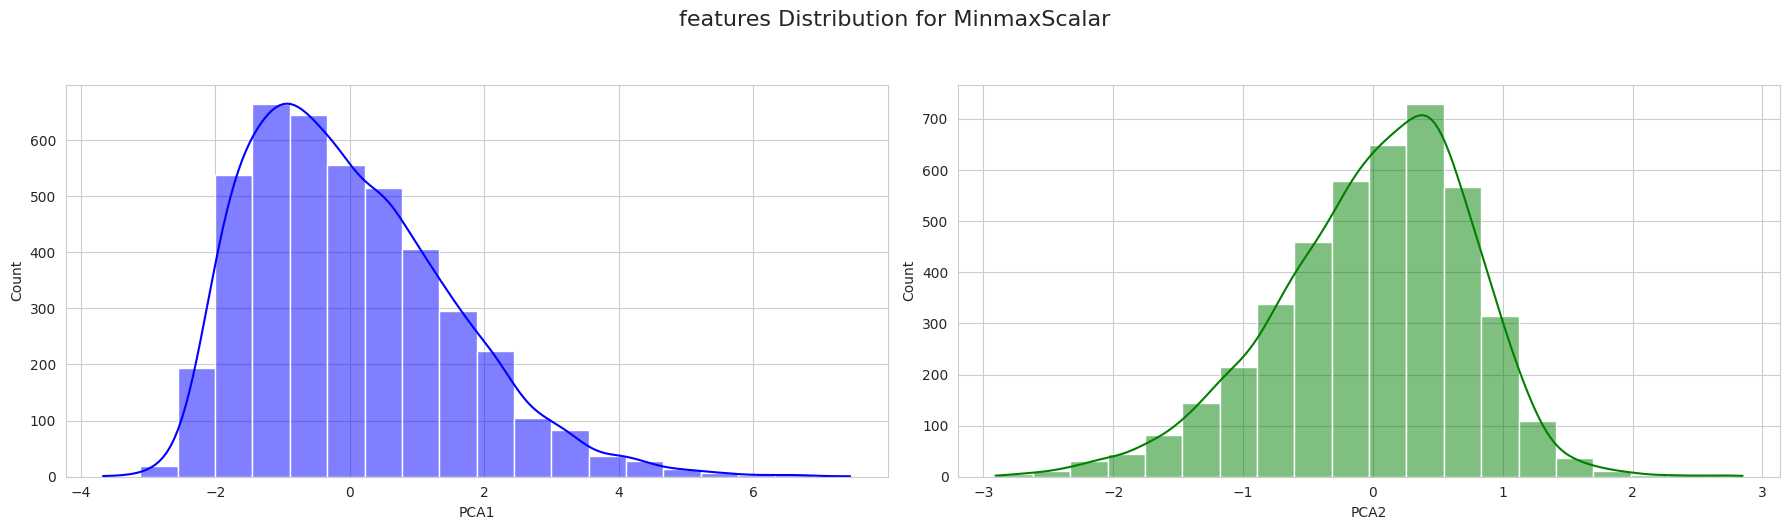

In [70]:
# style of the graph
sns.set_style("whitegrid")

# Subplots for each RFM feature
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot Recency distribution
sns.histplot(rfm_std["PCA1"], bins=20, kde=True, ax=axes[0], color="blue")

# Plot Frequency distribution
sns.histplot(rfm_std["PCA2"], bins=20, kde=True, ax=axes[1], color="green")

# Add main title to the figure
fig.suptitle("features Distribution for MinmaxScalar", fontsize=16, y=1.05)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


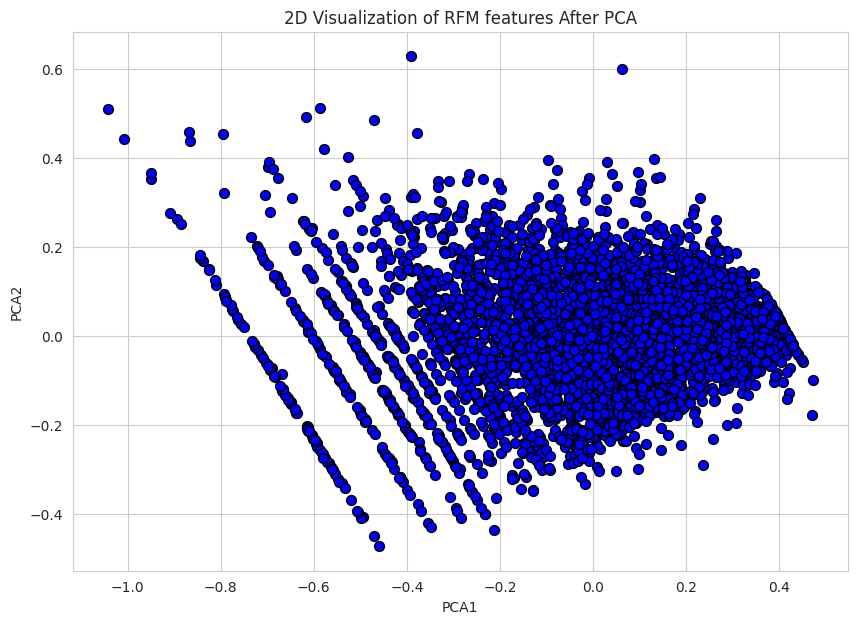

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create a 2D scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(rfm_df["PCA1"], rfm_df["PCA2"], s=50, edgecolor='k', color='blue')

# Labels and title
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("2D Visualization of RFM features After PCA")

# Show the plot
plt.show()


**Using Elbow Method To find The Optimal Number Of Clusters**

The results represent the best number of components that will be used in Spectral Clustering and Britch clustering algorithms.

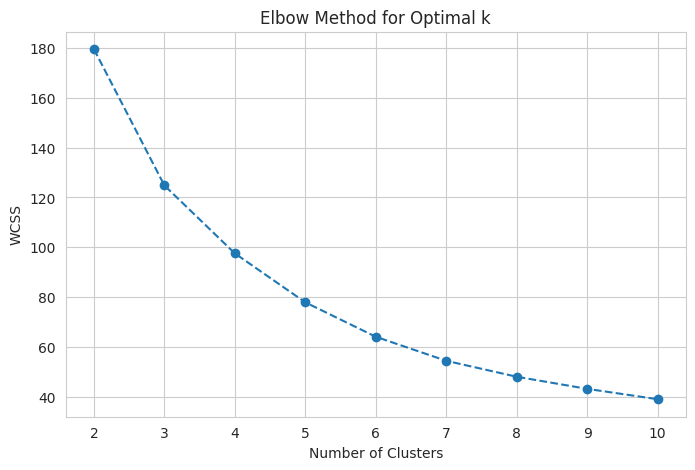

In [72]:
from sklearn.cluster import KMeans

# Initialize an empty list to store Within-Cluster Sum of Squares values
wcss = []

# Define the range of cluster numbers to test (from 2 to 10 clusters)
K_range = range(2, 11)

# Iterate over different values of k to find the optimal number of clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Initialize K-Means with k clusters
    kmeans.fit(rfm_df)  # Fit the model to the minmax RFM data
    wcss.append(kmeans.inertia_)  # Store the WCSS value for this k (lower is better)

plt.figure(figsize=(8, 5))

# Plot the WCSS values against the number of clusters
plt.plot(K_range, wcss, marker='o', linestyle='--')

# Label the axes
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

# Add a title to the plot
plt.title("Elbow Method for Optimal k")

# Display the plot
plt.show()


In [22]:
!pip install kneed

**Optimal eps and min sample Selection for DBSCAN**

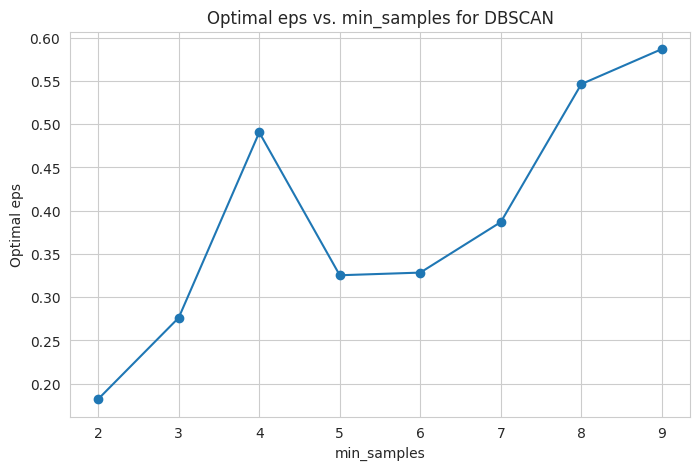

Optimal min_samples for DBSCAN: 9


In [84]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np



# Define a range of min_samples values to test
min_samples_values = range(2, 10)

# Store average k-distance for each min_samples
eps_values = []

for min_samples in min_samples_values:
    # Compute k-distances
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors.fit(rfm_std)
    distances, indices = neighbors.kneighbors(rfm_std)

    # Sort and take the k-th nearest distance
    sorted_distances = np.sort(distances[:, -1])

    # Find the knee (elbow point)
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    optimal_eps = sorted_distances[kneedle.elbow]

    eps_values.append(optimal_eps)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(min_samples_values, eps_values, marker="o")
plt.xlabel("min_samples")
plt.ylabel("Optimal eps")
plt.title("Optimal eps vs. min_samples for DBSCAN")
plt.grid(True)
plt.show()

# Print best min_samples value
best_min_samples = min_samples_values[np.argmax(eps_values)]
print(f"Optimal min_samples for DBSCAN: {best_min_samples}")


Optimal epsilon (eps) for DBSCAN: 0.5866175688774189


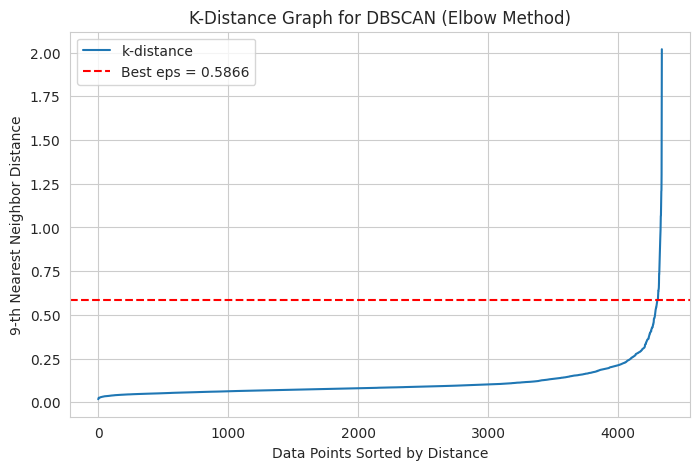

In [86]:
import numpy as np

# Set min_samples for DBSCAN
min_samples = best_min_samples

# Fit NearestNeighbors to find k-th nearest neighbor distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(rfm_std)
distances, indices = neighbors.kneighbors(rfm_std)

# Sort the distances (use only the k-th nearest neighbor distance)
distances = np.sort(distances[:, -1])

# Find the optimal eps using the KneeLocator (Elbow Method)
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
best_eps = distances[kneedle.elbow]  # Extract the best epsilon value

# Print the best eps
print(f"Optimal epsilon (eps) for DBSCAN: {best_eps}")

# Plot the k-distance graph with the elbow point
plt.figure(figsize=(8, 5))
plt.plot(distances, label="k-distance")
plt.axhline(y=best_eps, color='r', linestyle='--', label=f"Best eps = {best_eps:.4f}")
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN (Elbow Method)")
plt.legend()
plt.grid(True)
plt.show()


**Optimal Number of Clusters for GMM**

The following method determine the optimal number of clusters for segmenting RFM data using a Gaussian Mixture Model. It iterates over a range of cluster counts from 2 to 10, fits a GMM for each specified number of clusters on the RFM data , and calculates the Bayesian Information Criterion (BIC) for each model. The BIC score balances the model fit against its complexity. By comparing these BIC scores, the model with the lowest score can be identified as the best compromise between accuracy and simplicity, thereby guiding the selection of the optimal number of clusters for effective customer segmentation.

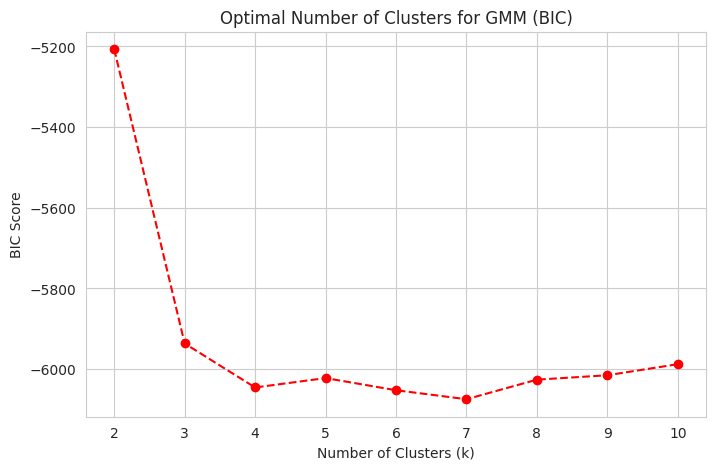

In [87]:
from sklearn.mixture import GaussianMixture

bic_scores = []  # Initialize an empty list to store BIC scores

for k in range(2, 11):  # Iterate over different numbers of clusters (from 2 to 10)
    gmm = GaussianMixture(n_components=k, random_state=42)  # Initialize Gaussian Mixture Model with k clusters
    gmm.fit(rfm_df)  # Fit the model to the RFM data
    bic_scores.append(gmm.bic(rfm_df))  # Compute and store the Bayesian Information Criterion (BIC) score


# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), bic_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("Optimal Number of Clusters for GMM (BIC)")
plt.show()


In [26]:
!pip install pyclustering


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395099 sha256=c22fc24ef14e29dcfe1d2140bb0f87c51c8dddb6653c70cd72312ca077673842
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [95]:
from sklearn.cluster import SpectralClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.clique import clique

# Clustering Algorithms
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering(n_clusters=3, affinity='rbf', random_state=42),
    "BIRCH": Birch(n_clusters=3, threshold = 0.1),
    "DBSCAN": DBSCAN(eps=0.58 , min_samples=4),
    "Gaussian Mixture Model": GaussianMixture(n_components=3, random_state=42),
    "CLIQUE": clique
}


In [96]:
# Compute Clustering Results
cluster_results = {}
validation_scores = {}

# Fit each clustering model and store results
for name, algorithm in clustering_algorithms.items():
    if name == "CLIQUE":
        # CLIQUE instantiation
        clique_instance = clique(rfm_df.values.tolist(), 10, 2)
        clique_instance.process()
        clusters = clique_instance.get_clusters()

        # Assign labels manually
        labels = [-1] * len(rfm_df)  # Default label for noise points
        for cluster_id, cluster in enumerate(clusters):
            for idx in cluster:
                labels[idx] = cluster_id  # Assign each point to a cluster

    elif name == "DBSCAN":
        # Use scaled features for DBSCAN
        labels = algorithm.fit_predict(rfm_std)

    else:
        # Fit sklearn-compatible models with original features
        labels = algorithm.fit_predict(rfm_df)

    cluster_results[name] = labels  # Store cluster labels

# Now iterate over cluster_results (which is no longer empty)
for name, labels in cluster_results.items():
    unique_labels = set(labels)
    print(f"{name} - Unique Clusters Found: {len(unique_labels)}")


Spectral Clustering - Unique Clusters Found: 3
BIRCH - Unique Clusters Found: 3
DBSCAN - Unique Clusters Found: 3
Gaussian Mixture Model - Unique Clusters Found: 3
CLIQUE - Unique Clusters Found: 3


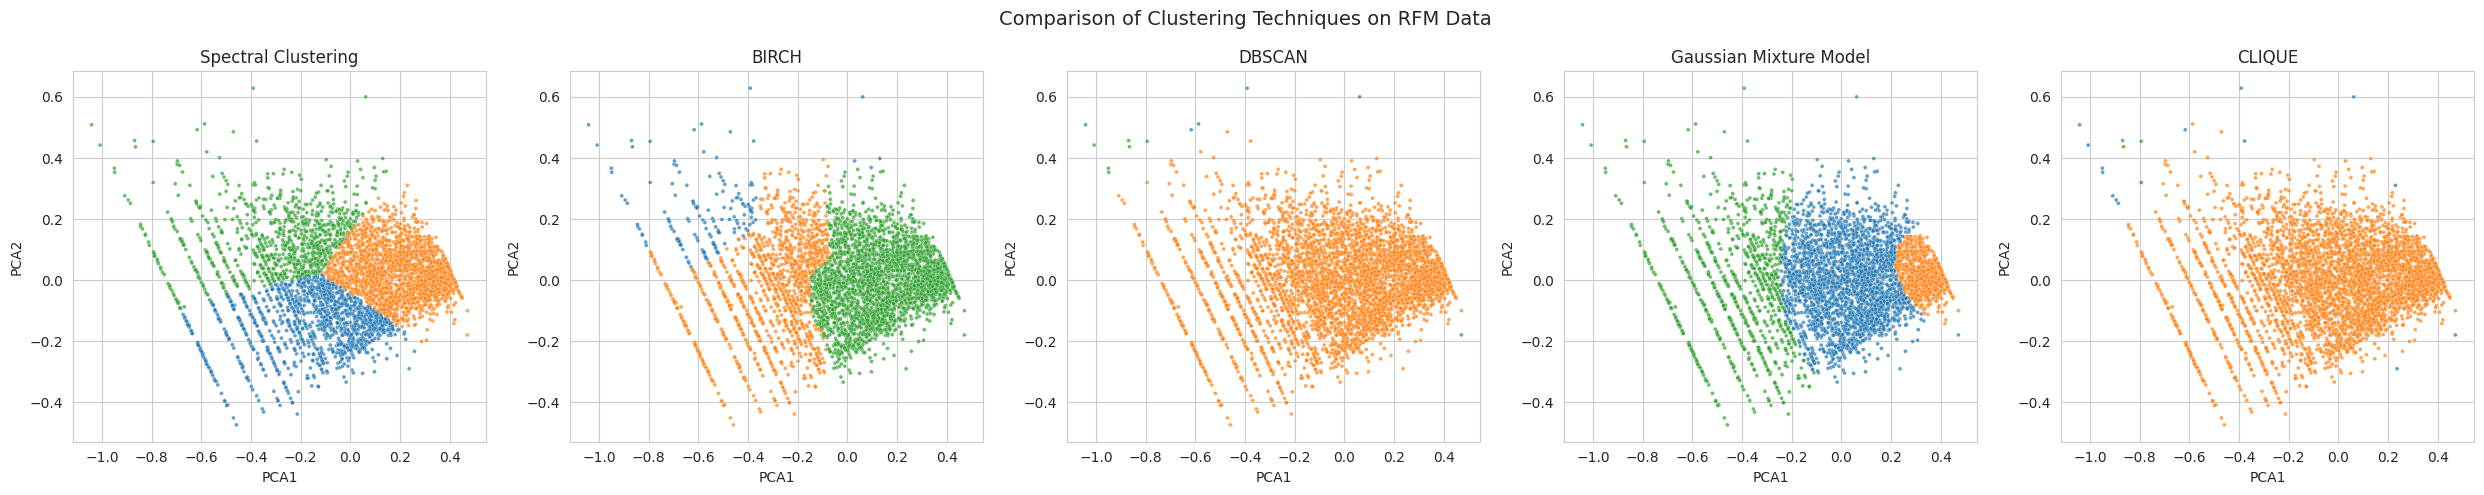

In [97]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# Compute validation metrics for each clustering method
for name, labels in cluster_results.items():
    # Choose the correct dataset based on the clustering algorithm
    if name == "DBSCAN":
        data = rfm_std # Use standardized features for DBSCAN
    else:
        data = rfm_df  # Use the RFM-normalized dataset for other clustering models

    # Compute clustering validation metrics only if there is more than one cluster
    if len(set(labels)) > 1:  # Silhouette Score requires at least 2 clusters
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = -1  # Assign -1 when only one cluster exists to avoid errors

    # Compute Davies-Bouldin Index (lower is better)
    db_index = davies_bouldin_score(data, labels)

    # Compute Calinski-Harabasz Index (higher is better)
    ch_index = calinski_harabasz_score(data, labels)

    # Store validation scores in a dictionary
    validation_scores[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

# Get the number of clustering methods used
num_clusters = len(cluster_results)

# Create subplots dynamically based on the number of clustering techniques
fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 5))
fig.suptitle("Comparison of Clustering Techniques on RFM Data", fontsize=14)

# If only one clustering method exists, make sure axes is iterable
if num_clusters == 1:
    axes = [axes]

# Iterate through the clustering results and visualize the clusters
for i, (name, labels) in enumerate(cluster_results.items()):
    unique_labels = len(set(labels))  # Get number of unique clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels)  # Define color palette

    # Scatter plot for visualizing clustering on Recency vs Frequency
    sns.scatterplot(
        x=rfm_df["PCA1"],  # X-axis: Recency
        y=rfm_df["PCA2"],  # Y-axis: Frequency
        hue=labels,  # Color clusters by labels
        palette=palette,  # Use color palette based on unique labels
        alpha=0.7,  # Set transparency for better visibility
        s=8,  # Set point size
        ax=axes[i]  # Assign plot to the respective subplot
    )

    # Set plot title and axis labels
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("PCA1")
    axes[i].set_ylabel("PCA2")

    # Remove legends from each subplot to avoid redundancy
    axes[i].legend([], frameon=False)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plots
plt.show()


In [98]:
# Convert validation scores to DataFrame
validation_df = pd.DataFrame(validation_scores).T

# Print the validation scores
validation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
Spectral Clustering,0.367353,1.094271,3253.643263
BIRCH,0.412376,0.960527,2864.828408
DBSCAN,0.605617,1.202921,63.484036
Gaussian Mixture Model,0.338388,0.847288,3813.912074
CLIQUE,0.532826,1.445112,47.537802
